In [1]:
print(_IMPORTS)

import datetime as dt
from collections import defaultdict, Counter, namedtuple
from itertools import product, combinations, permutations
import json
import os
import pickle
import warnings

from IPython.display import HTML, display, set_matplotlib_formats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sqlalchemy import create_engine
from tqdm.auto import tqdm

# INITIALIZING
# warnings
warnings.filterwarnings('ignore')
# pictures
sns.set()
plt.style.use('seaborn-bright')
plt.rcParams['figure.figsize'] = 10, 6
# pandas
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 100)
tqdm.pandas()

# Autoreload
get_ipython().magic(u"%reload_ext autoreload")
get_ipython().magic(u"%autoreload 2")
get_ipython().magic(u"%load_ext line_profiler")



In [2]:
import re

from glob import glob

from typing import List, Optional

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text

In [5]:
import torch
from transformers import AutoTokenizer, AutoModelForMaskedLM, AutoConfig

### Sampling on patients

In [6]:
PATH = "../data/raw/"
PATH_PROCESSED = "../data/processed/"
PATH_DATASETS = "../data/train/"

In [7]:
SAMPLE_SIZE = 1000
RANDOM_SEED = 1

In [8]:
patients = pd.read_csv(os.path.join(PATH, "PATIENTS.csv.gz"))
patients.EXPIRE_FLAG.value_counts()

0    30761
1    15759
Name: EXPIRE_FLAG, dtype: int64

In [9]:
#ensuring every patient is unique
print(f"{patients.SUBJECT_ID.nunique()} unique patients in {len(patients)} rows")
#sampling random patients
patients_sample = patients.sample(n=SAMPLE_SIZE, random_state=RANDOM_SEED)

46520 unique patients in 46520 rows


In [10]:
SAMPLE_IDS = set(patients_sample.SUBJECT_ID)

with open(os.path.join(PATH_PROCESSED, "SAMPLE_IDS.json"), 'w') as f:
    json.dump({'ids': list(SAMPLE_IDS)}, f)
    
with open(os.path.join(PATH_PROCESSED, "SAMPLE_IDS.json"), 'r') as f:
    SAMPLE_IDS = set(json.load(f)['ids'])

In [11]:
patients_sample = patients[patients.SUBJECT_ID.isin(SAMPLE_IDS)]

In [12]:
patients_sample.head()

,ROW_ID,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
10,244,261,M,2025-08-04 00:00:00,2102-06-29 00:00:00,2102-06-29 00:00:00,2102-06-29 00:00:00,1
85,691,734,F,2102-05-28 00:00:00,NaN,NaN,NaN,0
113,719,763,M,2148-08-05 00:00:00,NaN,NaN,NaN,0
115,721,765,F,2050-05-27 00:00:00,2134-07-15 00:00:00,2134-07-15 00:00:00,2134-07-15 00:00:00,1
196,802,852,M,2108-05-05 00:00:00,NaN,NaN,NaN,0


In [13]:
DECEASED_TO_DATE = patients_sample[patients_sample.EXPIRE_FLAG == 1]\
    .set_index('SUBJECT_ID').DOD.map(lambda x: pd.to_datetime(x).date()).to_dict()

In [14]:
def get_data_for_sample(sample_ids: set, 
                        file_name: str, 
                        chunksize: int = 10_000) -> pd.DataFrame:
    """Get the data only relevant for the sample."""
    full_path = os.path.join(PATH, file_name)
    iterator = pd.read_csv(full_path, iterator=True, chunksize=chunksize)
    return pd.concat([chunk[chunk.SUBJECT_ID.isin(SAMPLE_IDS)] for chunk in tqdm(iterator)])

### Build features

All features in feature_prepocessed form are features with columns ['SUBJECT_ID', 'FEATURE_NAME', 'DATE', 'VALUE], which can be later used for any of the aggregations we'd like.

In [15]:
admissions = get_data_for_sample(SAMPLE_IDS, "ADMISSIONS.csv.gz")

0it [00:00, ?it/s]

In [16]:
admissions['ADMITTIME'] = pd.to_datetime(admissions.ADMITTIME).dt.date

In [229]:
diagnoses = get_data_for_sample(SAMPLE_IDS, "DIAGNOSES_ICD.csv.gz")

0it [00:00, ?it/s]

In [18]:
lab_results = get_data_for_sample(SAMPLE_IDS, "LABEVENTS.csv.gz", chunksize=100_000)

0it [00:00, ?it/s]

In [19]:
meds = get_data_for_sample(SAMPLE_IDS, "PRESCRIPTIONS.csv.gz")

0it [00:00, ?it/s]

#### Diagnoses

In [20]:
diagnoses['ICD9_CODE'] = "ICD9_" + diagnoses['ICD9_CODE']

In [21]:
adm_cols = ['SUBJECT_ID', 'HADM_ID', 'ADMITTIME']
diagnoses = diagnoses.merge(admissions[adm_cols], on=['SUBJECT_ID', 'HADM_ID'])

In [22]:
dropper = ['ROW_ID', 'SEQ_NUM', 'HADM_ID']
renamer = {'ICD9_CODE': 'FEATURE_NAME', 'ADMITTIME': 'DATE'}
diag_preprocessed = diagnoses.drop(columns=dropper).rename(columns=renamer)
diag_preprocessed['VALUE'] = 1

In [23]:
diag_preprocessed.head()

,SUBJECT_ID,FEATURE_NAME,DATE,VALUE
0,138,ICD9_1890,2134-03-01,1
1,138,ICD9_4254,2134-03-01,1
2,138,ICD9_4280,2134-03-01,1
3,138,ICD9_V4502,2134-03-01,1
4,138,ICD9_V5861,2134-03-01,1


#### Labs

In [24]:
lab_results['DATE'] = pd.to_datetime(lab_results['CHARTTIME']).dt.date

In [25]:
lab_results['FEATURE_NAME'] = "LAB_" + lab_results['ITEMID'].astype(str)

In [26]:
dropper = ['ROW_ID', 'HADM_ID', 'VALUE', 'VALUEUOM', 'FLAG', 'ITEMID', 'CHARTTIME']
renamer = {'VALUENUM': 'VALUE'}
lab_preprocessed = lab_results.drop(columns=dropper).rename(columns=renamer)

In [27]:
lab_preprocessed.head()

,SUBJECT_ID,VALUE,DATE,FEATURE_NAME
70116,138,30.00,2134-01-06,LAB_50804
70117,138,1.12,2134-01-06,LAB_50808
70118,138,35.00,2134-01-06,LAB_50818
70119,138,7.52,2134-01-06,LAB_50820
70120,138,131.00,2134-01-06,LAB_50821


#### Meds

In [28]:
meds = meds[meds.ENDDATE.notna()]

In [29]:
meds['DATE'] = pd.to_datetime(meds['ENDDATE']).dt.date

In [30]:
def find_mean_dose(dose: str) -> float:
    if pd.isnull(dose):
        return 0
    try:
        cleaned = re.sub(r'[A-Za-z,>< ]', '', dose)
        parts = cleaned.split('-')
        return np.array(parts).astype(float).mean()
    except:
        print(dose)

In [31]:
meds['VALUE'] = meds['DOSE_VAL_RX'].map(find_mean_dose)

In [32]:
meds['FEATURE_NAME'] = "MED_" + meds['GSN'].astype(str)

In [33]:
dropper = [col for col in meds.columns if col not in {'SUBJECT_ID', 'DATE', 'FEATURE_NAME', 'VALUE'}]
meds_preprocessed = meds.drop(columns=dropper).rename(columns=renamer)

In [34]:
meds_preprocessed.head()

,SUBJECT_ID,DATE,VALUE,FEATURE_NAME
9807,138,2134-01-11,487.5,MED_004481
9808,138,2134-01-05,50.0,MED_001210
9809,138,2134-01-05,1.5,MED_008920
9810,138,2134-01-06,1.0,MED_014198
9811,138,2134-01-06,20.0,MED_008205


#### Notes

Here we can preprocess notes. Later the same things can be done using Spark.

In [35]:
def get_notes(sample_ids: set = None,
              note_path: str = "NOTEEVENTS.csv.gz",
              chunksize: int = 10_000) -> pd.DataFrame:
    """Get all notes or only those relevant for the sample."""
    if sample_ids is None:
        return pd.read_csv(os.path.join(PATH, note_path))
    return get_data_for_sample(sample_ids, note_path, chunksize)

In [36]:
notes = get_notes(SAMPLE_IDS)
# notes.to_csv(os.path.join(PATH_PROCESSED, 'SAMPLE_NOTES.csv'), index=False)

# notes = pd.read_csv(os.path.join(PATH_PROCESSED, 'SAMPLE_NOTES.csv'))

0it [00:00, ?it/s]

In [37]:
notes.head()

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
12,223,5350,169684.0,2143-04-30,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2143-4-25**] Discharge...
13,224,5350,169684.0,2143-04-30,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2143-4-25**] Discharge...
338,340,59977,127266.0,2143-11-23,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2143-11-17**] ...
464,474,1675,185767.0,2155-07-08,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2155-7-4**] Discharg...
750,1036,55873,137057.0,2193-09-16,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2193-8-29**] ...


In [38]:
notes['DATE'] = pd.to_datetime(notes['CHARTDATE']).dt.date

In [39]:
def clean_text(note: str):
    cleaned = re.sub(r'[^\w]', ' ', note).replace("_", " ")
    removed_spaces = re.sub(' +', ' ', cleaned)
    lower = removed_spaces.lower()
    return lower

In [40]:
notes['CLEAN_TEXT'] = notes['TEXT'].map(clean_text)

In [41]:
notes.head()

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT,DATE,CLEAN_TEXT
12,223,5350,169684.0,2143-04-30,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2143-4-25**] Discharge...,2143-04-30,admission date 2143 4 25 discharge date 2143 4...
13,224,5350,169684.0,2143-04-30,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2143-4-25**] Discharge...,2143-04-30,admission date 2143 4 25 discharge date 2143 4...
338,340,59977,127266.0,2143-11-23,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2143-11-17**] ...,2143-11-23,admission date 2143 11 17 discharge date 2143 ...
464,474,1675,185767.0,2155-07-08,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2155-7-4**] Discharg...,2155-07-08,admission date 2155 7 4 discharge date 2155 7 ...
750,1036,55873,137057.0,2193-09-16,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2193-8-29**] ...,2193-09-16,admission date 2193 8 29 discharge date 2193 9...


#### Notes processing
Let's see if we can choose some subparts of notes that will contain more information.

In [42]:
notes.CATEGORY.value_counts()

Nursing/other        20308
Radiology            11237
ECG                   4528
Nursing               3717
Physician             2152
Discharge summary     1296
Echo                  1007
Respiratory            512
Nutrition              140
General                135
Rehab Services          87
Social Work             38
Case Management         18
Name: CATEGORY, dtype: int64

Let's see how how often patients have different kinds of notes

In [43]:
has_note_type = notes.groupby(['SUBJECT_ID', 'CATEGORY']).HADM_ID.count().unstack().fillna(0) > 0

In [44]:
(has_note_type.sum() / has_note_type.shape[0]).sort_values(ascending=False)

CATEGORY
Discharge summary    0.879032
Radiology            0.773185
ECG                  0.720766
Nursing/other        0.638105
Echo                 0.445565
Nursing              0.151210
Physician            0.147177
Respiratory          0.072581
General              0.054435
Nutrition            0.048387
Rehab Services       0.046371
Social Work          0.021169
Case Management      0.013105
dtype: float64

Let's see if having some kind of notes correlates with mortality

In [45]:
has_note_type['DECEASED'] = has_note_type.index.isin(DECEASED_TO_DATE)

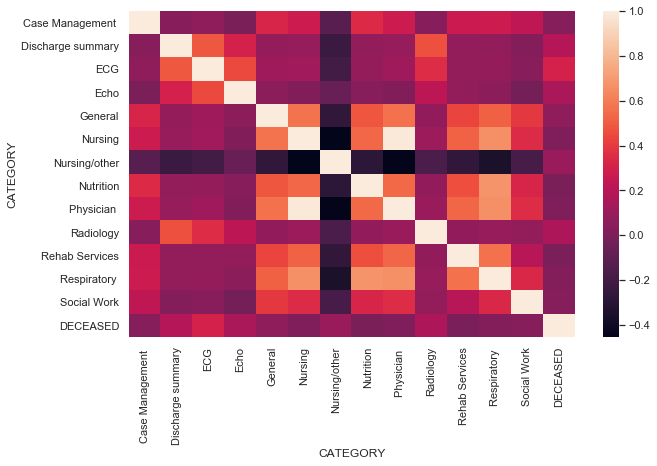

In [46]:
sns.heatmap(has_note_type.corr())

Nothing too severe, let's see last discharge notes for some alive and deceased patients

In [47]:
deceased_notes = notes[(notes.CATEGORY == 'Discharge summary') & notes.SUBJECT_ID.isin(DECEASED_TO_DATE)]

In [48]:
cols_to_use = ['SUBJECT_ID', 'DATE']
for _, row in deceased_notes.sort_values(cols_to_use, ascending=[True, False])\
        .drop_duplicates(cols_to_use).iloc[:3].iterrows():
    pass
#     print(row['TEXT'])
#     print('\n' * 3)

If we print the previous results we see that deceased patients don't have some explicit mention of their death later, so there should not be major data leaks

In [49]:
deceased_notes.TEXT.map(lambda x: 'deceased' in x.lower()).value_counts()

False    491
True      27
Name: TEXT, dtype: int64

That helps us to conclude that direct pointers to death can rarely be found in discharge notes

#### Splitting discharge notes into parts

In [50]:
cols_to_use = ['SUBJECT_ID', 'DATE']
discharge_notes = notes[notes.CATEGORY == 'Discharge summary']\
    .sort_values(cols_to_use, ascending=[True, False])\
    .drop_duplicates(cols_to_use)

In [51]:
discharge_notes.SUBJECT_ID.nunique(), discharge_notes.shape[0]

(872, 1203)

In [52]:
discharge_notes.TEXT.map(lambda x: 'history ' in x.lower()).sum()

1119

Let's try to use only the history part of discharge notes

In [53]:
def prepare_text_for_tokenizer(text: str):
    cleaned = ('. ').join(text.splitlines())
    removed_symbols = re.sub('[\[\]\*\_#:?!]+', ' ', cleaned)
    removed_spaces = re.sub(' +', ' ', removed_symbols)
    removed_dots = re.sub('\. \.| \.', '.', removed_spaces)
    removed_duplicated_dots = re.sub('\.+', '.', removed_dots)
    return removed_duplicated_dots

In [54]:
discharge_notes['TO_TOK'] = discharge_notes.TEXT.map(prepare_text_for_tokenizer)

In [55]:
discharge_notes['HISTORY'] = discharge_notes['TO_TOK'].map(lambda x: x.lower().split('history')[-1])

### Feature construction

We need to take into account only the events that happened during the observation window. The end of observation window is N days before death for deceased patients and date of last event for alive patients. We can have several sets of events (e.g. labs, diags, meds), so we need to choose the latest date out of those.

In [56]:
OBSERVATION_WINDOW = 2000
PREDICTION_WINDOW = 50

In [57]:
def define_train_period(*feature_sets, 
                        obs_w: int = OBSERVATION_WINDOW, 
                        pred_w: int = PREDICTION_WINDOW) -> (dict, dict):
    """Create SUBJECT_ID -> earliest_date and SUBJECT_ID -> last date dicts."""
    cols = ['SUBJECT_ID', 'DATE']
    all_feats = pd.concat([feats[cols] for feats in feature_sets])
    last_date_base = all_feats.groupby('SUBJECT_ID').DATE.max().to_dict()
    last_date = {subj_id: date
                 for subj_id, date in last_date_base.items()
                 if subj_id not in DECEASED_TO_DATE}
    subtracted_pred_w = {subj_id: date - dt.timedelta(days=pred_w)
                         for subj_id, date in DECEASED_TO_DATE.items()}
    last_date.update(subtracted_pred_w)
    earliest_date = {subj_id: date - dt.timedelta(days=obs_w)
                     for subj_id, date in last_date.items()}
    return earliest_date, last_date

In [58]:
def clean_up_feature_sets(*feature_sets, earliest_date: dict, last_date: dict) -> list:
    """Leave only features from inside the observation window."""
    results = []
    for feats in feature_sets:
        results.append(feats[(feats.DATE < feats.SUBJECT_ID.map(last_date))
                             & (feats.DATE >= feats.SUBJECT_ID.map(earliest_date))])
    return results

In [59]:
use_feature_sets = [diag_preprocessed, lab_preprocessed, meds_preprocessed]

In [60]:
earliest_date, last_date = define_train_period(*use_feature_sets)

In [61]:
diag, lab, med = clean_up_feature_sets(*use_feature_sets, earliest_date=earliest_date, last_date=last_date)

#### Feat calculations

We are going to do a train test split based on patients to validate our model. We will only use those features that appear in the train set. Also, we will only use features that are shared between many patients (we will define "many" manually for each of the feature sets).  

This way we will lose some patients who don't have "popular" features, but that's fine since our goal is to compare similar patients, not to train the best model.

In [62]:
TRAIN_SIZE = 0.8

In [63]:
TRAIN_IDS, TEST_IDS = train_test_split(list(SAMPLE_IDS), train_size=TRAIN_SIZE, random_state=RANDOM_SEED)

In [64]:
def build_feats(df: pd.DataFrame, agg: list, train_ids: list = None, low_thresh: int = None) -> pd.DataFrame:
    """Build feature aggregations for patient.
    
    Args:
        agg: list of aggregations to use
        train_ids: if not empty, only features that exist in the train set 
            will be used
        low_thresh: if not empty, only features that more than low_thresh
            patients have will be used
    """
    cols_to_use = ['SUBJECT_ID', 'FEATURE_NAME']
    print(f"Total feats: {df.FEATURE_NAME.nunique()}")
    
    if train_ids is not None:
        train_df = df[df.SUBJECT_ID.isin(train_ids)]
        train_feats = set(train_df.FEATURE_NAME)
        df = df[df.FEATURE_NAME.isin(train_feats)]
        print(f"Feats after leaving only train: {len(train_feats)}")
        
    if low_thresh is not None:
        deduplicated = df.drop_duplicates(cols_to_use)
        count = Counter(deduplicated.FEATURE_NAME)
        features_to_leave = set(feat for feat, cnt in count.items() if cnt > low_thresh)
        df = df[df.FEATURE_NAME.isin(features_to_leave)]
        print(f"Feats after removing rare: {len(features_to_leave)}")
    
    grouped = df.groupby(cols_to_use).VALUE.agg(agg)
    return grouped

In [65]:
def pivot_aggregation(df: pd.DataFrame, fill_value = None, use_sparse: bool = True) -> pd.DataFrame:
    """Make sparse pivoted table with SUBJECT_ID as index."""
    pivoted = df.unstack()
    if fill_value is not None:
        pivoted = pivoted.fillna(fill_value)
    
    if use_sparse:
        pivoted = pivoted.astype(pd.SparseDtype("float", fill_value))

    pivoted.columns = [f"{col[-1]}_{col[0]}" for col in pivoted.columns]
    return pivoted

In [66]:
diag_built = build_feats(diag, agg=['count'], train_ids=TRAIN_IDS, low_thresh=30)

Total feats: 1821
Feats after leaving only train: 1643
Feats after removing rare: 52


In [67]:
diag_final = pivot_aggregation(diag_built, fill_value=0)

In [68]:
diag_final.head()

,ICD9_0389_count,ICD9_2449_count,ICD9_25000_count,ICD9_2720_count,ICD9_2724_count,ICD9_2749_count,ICD9_2761_count,ICD9_2762_count,ICD9_2767_count,ICD9_2851_count,ICD9_2859_count,ICD9_2875_count,ICD9_3051_count,ICD9_311_count,ICD9_4019_count,ICD9_40390_count,ICD9_41071_count,ICD9_412_count,ICD9_41401_count,ICD9_4168_count,ICD9_4240_count,ICD9_4241_count,ICD9_42731_count,ICD9_42789_count,ICD9_4280_count,ICD9_4589_count,ICD9_486_count,ICD9_496_count,ICD9_5070_count,ICD9_5119_count,ICD9_5180_count,ICD9_51881_count,ICD9_53081_count,ICD9_5845_count,ICD9_5849_count,ICD9_5859_count,ICD9_5990_count,ICD9_769_count,ICD9_7742_count,ICD9_7793_count,ICD9_78039_count,ICD9_99592_count,ICD9_9971_count,ICD9_V053_count,ICD9_V1582_count,ICD9_V290_count,ICD9_V3000_count,ICD9_V3001_count,ICD9_V4581_count,ICD9_V502_count,ICD9_V5861_count,ICD9_V5867_count
SUBJECT_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
138,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,1.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
167,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
180,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
211,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
261,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [69]:
labs_built = build_feats(lab, agg=['mean', 'max', 'min'], train_ids=TRAIN_IDS, low_thresh=50)

Total feats: 543
Feats after leaving only train: 535
Feats after removing rare: 164


In [70]:
labs_final = pivot_aggregation(labs_built, fill_value=0)

In [71]:
labs_final.head()

,LAB_50800_mean,LAB_50801_mean,LAB_50802_mean,LAB_50803_mean,LAB_50804_mean,LAB_50806_mean,LAB_50808_mean,LAB_50809_mean,LAB_50810_mean,LAB_50811_mean,LAB_50812_mean,LAB_50813_mean,LAB_50815_mean,LAB_50816_mean,LAB_50817_mean,LAB_50818_mean,LAB_50819_mean,LAB_50820_mean,LAB_50821_mean,LAB_50822_mean,LAB_50823_mean,LAB_50824_mean,LAB_50825_mean,LAB_50826_mean,LAB_50827_mean,LAB_50828_mean,LAB_50852_mean,LAB_50856_mean,LAB_50861_mean,LAB_50862_mean,LAB_50863_mean,LAB_50867_mean,LAB_50868_mean,LAB_50878_mean,LAB_50879_mean,LAB_50880_mean,LAB_50882_mean,LAB_50883_mean,LAB_50884_mean,LAB_50885_mean,LAB_50887_mean,LAB_50889_mean,LAB_50893_mean,LAB_50902_mean,LAB_50903_mean,LAB_50904_mean,LAB_50905_mean,LAB_50907_mean,LAB_50908_mean,LAB_50909_mean,LAB_50910_mean,LAB_50911_mean,LAB_50912_mean,LAB_50917_mean,LAB_50919_mean,LAB_50920_mean,LAB_50922_mean,LAB_50924_mean,LAB_50925_mean,LAB_50930_mean,LAB_50931_mean,LAB_50933_mean,LAB_50935_mean,LAB_50952_mean,LAB_50953_mean,LAB_50954_mean,LAB_50955_mean,LAB_50956_mean,LAB_50960_mean,LAB_50963_mean,LAB_50964_mean,LAB_50967_mean,LAB_50970_mean,LAB_50971_mean,LAB_50976_mean,...,LAB_51074_min,LAB_51075_min,LAB_51078_min,LAB_51079_min,LAB_51082_min,LAB_51087_min,LAB_51090_min,LAB_51092_min,LAB_51093_min,LAB_51097_min,LAB_51099_min,LAB_51100_min,LAB_51102_min,LAB_51103_min,LAB_51104_min,LAB_51137_min,LAB_51143_min,LAB_51144_min,LAB_51146_min,LAB_51151_min,LAB_51200_min,LAB_51214_min,LAB_51221_min,LAB_51222_min,LAB_51233_min,LAB_51237_min,LAB_51244_min,LAB_51246_min,LAB_51248_min,LAB_51249_min,LAB_51250_min,LAB_51251_min,LAB_51252_min,LAB_51254_min,LAB_51255_min,LAB_51256_min,LAB_51257_min,LAB_51260_min,LAB_51265_min,LAB_51266_min,LAB_51267_min,LAB_51268_min,LAB_51274_min,LAB_51275_min,LAB_51277_min,LAB_51279_min,LAB_51283_min,LAB_51287_min,LAB_51288_min,LAB_51294_min,LAB_51296_min,LAB_51301_min,LAB_51462_min,LAB_51463_min,LAB_51464_min,LAB_51466_min,LAB_51476_min,LAB_51478_min,LAB_51479_min,LAB_51482_min,LAB_51484_min,LAB_51486_min,LAB_51487_min,LAB_51491_min,LAB_51492_min,LAB_51493_min,LAB_51498_min,LAB_51501_min,LAB_51506_min,LAB_51508_min,LAB_51512_min,LAB_51514_min,LAB_51516_min,LAB_51519_min,LAB_51523_min
SUBJECT_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
138,0.0,0.0,0.807692,0.0,27.076923,104.666667,1.134286,136.187500,34.636364,11.572727,0.0,1.450,0.0,46.666667,97.888889,44.230769,0.0,7.381071,195.000,4.447059,0.0,136.250000,0.0,0.0,0.0,0.0,0.0,0.0,110.40,3.516667,83.777778,116.333333,10.656250,54.00,0.0,0.0,27.468750,0.1,0.2,0.377778,0.0,0.0,8.577273,102.937500,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.100000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,115.531250,0.0,36.0,0.0,0.0,410.0,0.0,85.666667,1.94000,0.0,0.0,0.0,3.331818,4.162857,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4,0.0,1.1,323.0,26.8,9.2,0.0,1.0,19.3,0.0,28.7,31.7,85.0,0.0,0.0,5.0,0.0,71.4,0.0,0.0,81.0,0.0,0.0,0.0,12.2,29.5,12.8,3.02,0.0,0.0,0.0,0.0,0.0,6.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,1.030,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
167,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.000000,0.000000,15.500000,0.00,0.0,0.0,22.000000,0.3,7.6,7.900000,0.0,0.0,0.000000,109.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,4.350000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,5.0,0.0,42.8,15.1,0.0,0.0,57.0,0.0,36.3,35.4,103.0,0.0,0.0,5.0,0.0,32.0,2.0,0.0,353.0,0.0,0.0,0.0,0.0,0.0,17.3,4.16,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
180,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000,

In [72]:
meds_built = build_feats(med, agg=['mean', 'count'], train_ids=TRAIN_IDS, low_thresh=50)

Total feats: 2050
Feats after leaving only train: 1952
Feats after removing rare: 120


In [73]:
meds_final = pivot_aggregation(meds_built, fill_value=0)

In [74]:
meds_final.head()

,MED_000283_mean,MED_001187_mean,MED_001209_mean,MED_001210_mean,MED_001248_mean,MED_001255_mean,MED_001262_mean,MED_001285_mean,MED_001356_mean,MED_001417_mean,MED_001723_mean,MED_001972_mean,MED_001989_mean,MED_002006_mean,MED_002689_mean,MED_002944_mean,MED_002947_mean,MED_003009_mean,MED_003017_mean,MED_003026_mean,MED_003067_mean,MED_003753_mean,MED_003757_mean,MED_003779_mean,MED_004070_mean,MED_004072_mean,MED_004103_mean,MED_004222_mean,MED_004225_mean,MED_004376_mean,MED_004380_mean,MED_004478_mean,MED_004489_mean,MED_004758_mean,MED_004886_mean,MED_005039_mean,MED_005066_mean,MED_005068_mean,MED_005132_mean,MED_005229_mean,MED_006522_mean,MED_006532_mean,MED_006549_mean,MED_006562_mean,MED_008205_mean,MED_008208_mean,MED_009066_mean,MED_009588_mean,MED_011672_mean,MED_011673_mean,MED_011677_mean,MED_015361_mean,MED_016546_mean,MED_016796_mean,MED_016995_mean,MED_019187_mean,MED_019808_mean,MED_019964_mean,MED_021700_mean,MED_021732_mean,MED_022346_mean,MED_027413_mean,MED_027462_mean,MED_041384_mean,MED_041660_mean,MED_043952_mean,MED_045309_mean,MED_047635_mean,MED_048548_mean,MED_050631_mean,MED_057959_mean,MED_061716_mean,MED_063951_mean,MED_11673.0_mean,MED_1187.0_mean,...,MED_008208_count,MED_009066_count,MED_009588_count,MED_011672_count,MED_011673_count,MED_011677_count,MED_015361_count,MED_016546_count,MED_016796_count,MED_016995_count,MED_019187_count,MED_019808_count,MED_019964_count,MED_021700_count,MED_021732_count,MED_022346_count,MED_027413_count,MED_027462_count,MED_041384_count,MED_041660_count,MED_043952_count,MED_045309_count,MED_047635_count,MED_048548_count,MED_050631_count,MED_057959_count,MED_061716_count,MED_063951_count,MED_11673.0_count,MED_1187.0_count,MED_1210.0_count,MED_1248.0_count,MED_1255.0_count,MED_1262.0_count,MED_1285.0_count,MED_1356.0_count,MED_1417.0_count,MED_16546.0_count,MED_16796.0_count,MED_16995.0_count,MED_1723.0_count,MED_1972.0_count,MED_19808.0_count,MED_1989.0_count,MED_19964.0_count,MED_2006.0_count,MED_22346.0_count,MED_27413.0_count,MED_27462.0_count,MED_283.0_count,MED_2944.0_count,MED_2947.0_count,MED_3009.0_count,MED_3017.0_count,MED_3753.0_count,MED_4070.0_count,MED_41384.0_count,MED_4222.0_count,MED_4380.0_count,MED_43952.0_count,MED_4478.0_count,MED_4489.0_count,MED_45309.0_count,MED_47635.0_count,MED_5039.0_count,MED_50631.0_count,MED_5068.0_count,MED_5132.0_count,MED_5229.0_count,MED_57959.0_count,MED_61716.0_count,MED_63951.0_count,MED_6549.0_count,MED_8205.0_count,MED_nan_count
SUBJECT_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
138,0.0,0.0,0.0,75.0,40.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1000.0,0.0,0.0,0.0,100.0,100.0,0.0,0.0,0.75,0.0,0.0,0.0,0.0,1.75,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,1.0,0.0,0.0,0.0,40.0,0.0,0.0,0.0,40.0,40.0,0.0,12.5,0.0,0.0,0.0,150.0,1000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,13.0,1.0,0.0,0.0,0.0,2.0,2.0,0.0,4.0,0.0,3.0,8.0,5.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,1.0,1.0,2.0,0.0,0.0,1.0,3.0,3.0,2.0,0.0,4.0,0.0,4.0,1.0,0.0,0.0,0.0,0.0,2.0,14.0
167,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.

### Model Training

We will use random forest to automatically incorporate feature interrelations into our model.

In [82]:
def build_df_target(*baseline_feats, feats_to_merge_left: List[pd.DataFrame] = None):
    """Concatenate baseline dataset and left-merge additional features.
    
    All datasets should have SUBJECT_ID as index.
    """
    df_baseline = pd.concat(baseline_feats, axis=1).fillna(0)
    target = pd.Series(df_baseline.index.isin(DECEASED_TO_DATE), index=df_baseline.index, name='target')
    if feats_to_merge_left is None:
        return df_baseline, target
    else:
        merge_feats = pd.concat(feats_to_merge_left, axis=1)
        df_final = df_baseline.merge(merge_feats, left_index=True, right_index=True, how='left').fillna(0)
        return df_final, target

In [83]:
def train_and_predict(df: pd.DataFrame, target: pd.Series, classifier) -> np.array:
    train_loc = df.index.isin(TRAIN_IDS)
    try:
        classifier.fit(df[train_loc], target[train_loc])
        pred = classifier.predict_proba(df[~train_loc])[:, 1]
    except AttributeError:
        classifier.fit(df[train_loc].sparse.to_dense(), target[train_loc])
        pred = classifier.predict_proba(df[~train_loc].sparse.to_dense())[:, 1]
    return pred

In [91]:
def show_results(y_true, y_pred_proba, 
                 show_top_feats: Optional[int] = None, 
                 col_names: List[str] = None) -> None:
    """Print ROC-AUC score and possibly top feature importances."""
    print(f"ROC-AUC: {roc_auc_score(y_true, y_pred_proba):.3f}")
    if show_top_feats is not None:
        top_feats = pd.Series(cl.feature_importances_, index=col_names)\
            .sort_values(ascending=False).iloc[:show_top_feats]
        print()
        print(top_feats)

In [92]:
df, target = build_df_target(diag_final, meds_final, labs_final)

In [93]:
target.value_counts()

False    669
True     180
Name: target, dtype: int64

In [94]:
cl = RandomForestClassifier(random_state=RANDOM_SEED)

In [95]:
pred = train_and_predict(df, target, cl)

In [97]:
show_results(target[target.index.isin(TEST_IDS)], pred, show_top_feats=10, col_names=df.columns)

ROC-AUC: 0.820

LAB_51006_mean      0.013220
LAB_51006_max       0.012426
LAB_51277_max       0.011025
LAB_51006_min       0.010743
LAB_50912_max       0.010346
LAB_50912_mean      0.008611
LAB_50917_min       0.008590
MED_1248.0_mean     0.008404
LAB_50912_min       0.007992
MED_1248.0_count    0.006993
dtype: float64


### Add note TF-IDF

In [98]:
last_note = clean_up_feature_sets(notes, earliest_date=earliest_date, last_date=last_date)[0]

In [99]:
cols = ['SUBJECT_ID', 'DATE', 'CLEAN_TEXT']
last_note = last_note.sort_values(by=cols, ascending=False).drop_duplicates('SUBJECT_ID')[cols]

In [100]:
last_note = last_note[last_note.SUBJECT_ID.isin(SAMPLE_IDS)]

In [101]:
last_note

,SUBJECT_ID,DATE,CLEAN_TEXT
1225024,99283,2125-12-12,2125 12 12 9 30 am chest pa lat clip clip num...
1232101,98564,2124-05-02,2124 5 2 8 48 am carot cereb hospital1 clip c...
517784,98402,2111-03-08,title sicu hpi 55f s p fall down the stairs la...
1131526,98318,2145-06-08,2145 6 8 4 30 am chest portable ap clip clip ...
1068958,98051,2142-04-12,2142 4 12 1 34 pm pelvis ap inlet outlet in o...
...,...,...,...
6103,261,2102-01-12,admission date 2101 12 27 discharge date 2102 ...
937127,211,2197-12-27,2197 12 27 2 02 pm chest pa lat clip clip num...
1669437,180,2193-12-15,npn agree with coworker initials namepattern4 ...
1675682,167,2163-04-12,social work met with mother at the bedside yes...


In [102]:
stop_words = text.ENGLISH_STOP_WORDS
vectorizer = TfidfVectorizer(max_features=200, stop_words=stop_words)
tf_idf = vectorizer.fit_transform(last_note.CLEAN_TEXT)

In [103]:
cols = [f"TFIDF_{feat}" for feat in vectorizer.get_feature_names()]
tf_idf_feats = pd.DataFrame.sparse.from_spmatrix(tf_idf, columns=cols, index=last_note.SUBJECT_ID)

#### Training

In [104]:
df, target = build_df_target(diag_final, meds_final, labs_final, feats_to_merge_left=[tf_idf_feats])

In [105]:
target.value_counts()

False    669
True     180
Name: target, dtype: int64

In [106]:
cl = RandomForestClassifier(random_state=RANDOM_SEED)

In [107]:
pred = train_and_predict(df, target, cl)

In [108]:
show_results(target[target.index.isin(TEST_IDS)], pred, show_top_feats=10)

ROC-AUC: 0.865

376    0.016039
128    0.010914
704    0.008802
540    0.008580
580    0.007918
508    0.007686
677    0.007236
349    0.007181
344    0.007073
842    0.006515
dtype: float64


Better results, mostly from getting patient discharge information from notes.

### Add transformer embeddings

In [114]:
LAST_NOTE_EMBEDS_PATH = "../data/embeddings/"

In [140]:
last_note

,SUBJECT_ID,DATE,CLEAN_TEXT
1225024,99283,2125-12-12,2125 12 12 9 30 am chest pa lat clip clip num...
1232101,98564,2124-05-02,2124 5 2 8 48 am carot cereb hospital1 clip c...
517784,98402,2111-03-08,title sicu hpi 55f s p fall down the stairs la...
1131526,98318,2145-06-08,2145 6 8 4 30 am chest portable ap clip clip ...
1068958,98051,2142-04-12,2142 4 12 1 34 pm pelvis ap inlet outlet in o...
...,...,...,...
6103,261,2102-01-12,admission date 2101 12 27 discharge date 2102 ...
937127,211,2197-12-27,2197 12 27 2 02 pm chest pa lat clip clip num...
1669437,180,2193-12-15,npn agree with coworker initials namepattern4 ...
1675682,167,2163-04-12,social work met with mother at the bedside yes...


In [139]:
last_note = clean_up_feature_sets(notes, earliest_date=earliest_date, last_date=last_date)[0]

In [140]:
cols = ['SUBJECT_ID', 'DATE', 'TEXT']
last_note = last_note.sort_values(by=cols, ascending=False).drop_duplicates('SUBJECT_ID')[cols]

In [141]:
last_note = last_note[last_note.SUBJECT_ID.isin(SAMPLE_IDS)]

In [142]:
prepare_text_for_tokenizer(last_note['TEXT'].iloc[0])

' 2125-12-12 9 30 AM. CHEST (PA & LAT) Clip Clip Number (Radiology) 33276. Reason To better characterise LLL shadowing. Admitting Diagnosis STROKE;TELEMETRY;TRANSIENT ISCHEMIC ATTACK. Hospital 2 MEDICAL CONDITION. 54 year old woman with R lateral medullary syndrome and LLL shadowing. resolved. REASON FOR THIS EXAMINATION. To better characterise LLL shadowing. FINAL REPORT. HISTORY To assess for left lower lobe shadowing. FINDINGS In comparison with the study of 12-8 , the patient has taken a much. better inspiration. Continued enlargement of the cardiac silhouette, though. no evidence of vascular congestion or pleural effusion. The lungs are. essentially clear. '

In [143]:
last_note['TO_TOK'] = last_note.TEXT.map(prepare_text_for_tokenizer)

In [144]:
last_note = last_note.reset_index(drop=True)

In [145]:
last_note.head()

,SUBJECT_ID,DATE,TEXT,TO_TOK
0,99283,2125-12-12,[**2125-12-12**] 9:30 AM\n CHEST (PA & LAT) ...,2125-12-12 9 30 AM. CHEST (PA & LAT) Clip Cli...
1,98564,2124-05-02,[**2124-5-2**] 8:48 AM\n CAROT/CEREB [**Hospit...,2124-5-2 8 48 AM. CAROT/CEREB Hospital1 Clip ...
2,98402,2111-03-08,[**2111-3-8**] 10:27 AM\n CT HEAD W/O CONTRAST...,2111-3-8 10 27 AM. CT HEAD W/O CONTRAST Clip ...
3,98318,2145-06-08,[**2145-6-8**] 4:30 AM\n CHEST (PORTABLE AP) ...,2145-6-8 4 30 AM. CHEST (PORTABLE AP) Clip Cl...
4,98051,2142-04-12,"[**2142-4-12**] 1:34 PM\n PELVIS (AP, INLET & ...","2142-4-12 1 34 PM. PELVIS (AP, INLET & OUTLET..."


In [180]:
tokenizer = AutoTokenizer.from_pretrained("deepset/covid_bert_base")

In [181]:
config = AutoConfig.from_pretrained('deepset/covid_bert_base', output_hidden_states=True, output_attentions=True)

In [182]:
model = AutoModelForMaskedLM.from_pretrained("deepset/covid_bert_base", config=config)
model_structure = model.eval()

In [183]:
def get_vector_for_text(text: str, model, tokenizer, max_length: Optional[int] = None) -> torch.Tensor:
    """This can be made faster."""
    encoding = tokenizer(text, 
                         add_special_tokens=True, 
                         truncation=True, 
                         padding="max_length", 
                         return_attention_mask=True, 
                         return_tensors="pt", 
                         max_length=max_length)
    with torch.no_grad():
        outputs = model(**encoding)
        hs = outputs.hidden_states
        token_embeddings = torch.stack(hs, dim=0)
        token_embeddings = torch.squeeze(token_embeddings, dim=1)
        token_embeddings = token_embeddings.permute(1,0,2)
        token_vecs = hs[-2][0]
        text_embedding = torch.mean(token_vecs, dim=0)
        return text_embedding

In [184]:
def calculate_and_store_embeds(path: str, tokenizer, model, df: pd.DataFrame, 
                               text_col: str, embed_id: str = 'SUBJECT_ID', max_length: Optional[int] = None) -> None:
    
    for row_num, row in tqdm(df.iterrows(), 
                             total=df.shape[0]):
        text = row[text_col]
        subj_id = row[embed_id]
        embedding = get_vector_for_text(text, model, tokenizer, max_length=max_length)
        torch.save(embedding, os.path.join(path, f"{subj_id}.pt"))

In [185]:
%%time
sentence = get_vector_for_text(last_note.TO_TOK.iloc[0], model, tokenizer)

CPU times: user 2.8 s, sys: 167 ms, total: 2.97 s
Wall time: 758 ms


In [186]:
calculate_and_store_embeds(LAST_NOTE_EMBEDS_PATH,
                           tokenizer, model,
                           last_note,
                           text_col='TO_TOK')

  0%|          | 0/833 [00:00<?, ?it/s]

In [187]:
def get_embeds_df(path: str) -> pd.DataFrame:
    subj_ids = []
    embeds = []
    for file in tqdm(glob(path + '*')):
        name = file.split('/')[-1]
        subj_id = int(name.split('.')[0])
        embedding = torch.load(file)
        subj_ids.append(subj_id)
        embeds.append(np.array(embedding))
    embed_df = pd.DataFrame(embeds, index=subj_ids)
    embed_df.columns = [f"EMBED_{i}" for i in embed_df.columns]
    return embed_df

In [197]:
embed_df_cord = get_embeds_df(LAST_NOTE_EMBEDS_PATH)

  0%|          | 0/833 [00:00<?, ?it/s]

In [198]:
embed_df_cord.head()

,EMBED_0,EMBED_1,EMBED_2,EMBED_3,EMBED_4,EMBED_5,EMBED_6,EMBED_7,EMBED_8,EMBED_9,EMBED_10,EMBED_11,EMBED_12,EMBED_13,EMBED_14,EMBED_15,EMBED_16,EMBED_17,EMBED_18,EMBED_19,EMBED_20,EMBED_21,EMBED_22,EMBED_23,EMBED_24,EMBED_25,EMBED_26,EMBED_27,EMBED_28,EMBED_29,EMBED_30,EMBED_31,EMBED_32,EMBED_33,EMBED_34,EMBED_35,EMBED_36,EMBED_37,EMBED_38,EMBED_39,EMBED_40,EMBED_41,EMBED_42,EMBED_43,EMBED_44,EMBED_45,EMBED_46,EMBED_47,EMBED_48,EMBED_49,EMBED_50,EMBED_51,EMBED_52,EMBED_53,EMBED_54,EMBED_55,EMBED_56,EMBED_57,EMBED_58,EMBED_59,EMBED_60,EMBED_61,EMBED_62,EMBED_63,EMBED_64,EMBED_65,EMBED_66,EMBED_67,EMBED_68,EMBED_69,EMBED_70,EMBED_71,EMBED_72,EMBED_73,EMBED_74,...,EMBED_693,EMBED_694,EMBED_695,EMBED_696,EMBED_697,EMBED_698,EMBED_699,EMBED_700,EMBED_701,EMBED_702,EMBED_703,EMBED_704,EMBED_705,EMBED_706,EMBED_707,EMBED_708,EMBED_709,EMBED_710,EMBED_711,EMBED_712,EMBED_713,EMBED_714,EMBED_715,EMBED_716,EMBED_717,EMBED_718,EMBED_719,EMBED_720,EMBED_721,EMBED_722,EMBED_723,EMBED_724,EMBED_725,EMBED_726,EMBED_727,EMBED_728,EMBED_729,EMBED_730,EMBED_731,EMBED_732,EMBED_733,EMBED_734,EMBED_735,EMBED_736,EMBED_737,EMBED_738,EMBED_739,EMBED_740,EMBED_741,EMBED_742,EMBED_743,EMBED_744,EMBED_745,EMBED_746,EMBED_747,EMBED_748,EMBED_749,EMBED_750,EMBED_751,EMBED_752,EMBED_753,EMBED_754,EMBED_755,EMBED_756,EMBED_757,EMBED_758,EMBED_759,EMBED_760,EMBED_761,EMBED_762,EMBED_763,EMBED_764,EMBED_765,EMBED_766,EMBED_767
5285,-0.798802,0.130756,0.671988,-0.503266,0.321561,0.167486,-0.138109,0.283182,0.142994,-0.086918,0.140263,-0.117940,-0.134491,-0.162193,-0.184334,0.658178,0.637654,-0.340463,-0.512746,0.338170,0.990492,-0.499885,0.328712,0.459036,0.205726,0.165479,-0.164664,-0.676376,-0.046614,0.270833,0.700922,-0.117788,0.293810,-0.341717,0.631551,-0.430869,0.051414,-0.237179,0.380903,0.184331,-0.295622,-0.296313,0.011057,-0.000363,-0.522852,-0.027841,0.378444,-0.294858,-0.329169,-0.059924,-0.602925,-0.385992,0.456208,-0.223731,-0.057904,0.305034,-0.073592,0.166305,-0.382342,-0.245806,0.132887,-0.109450,-0.022951,0.221922,-0.166220,0.096496,0.056278,0.160964,-0.704472,0.355464,0.107311,0.002045,0.788721,0.161504,0.436051,...,-0.121475,-0.185049,0.282081,-0.030035,-0.410694,-0.204711,-0.309379,0.954139,-0.491521,-0.277130,0.209304,-0.029853,-0.255413,1.266172,0.111401,-0.116600,0.157362,-0.695698,-0.132504,0.333457,0.081255,-0.201507,0.728113,-0.056593,-0.100532,-0.303419,0.222861,0.131474,0.369915,-0.008144,0.067196,-0.373120,-0.313959,-0.502534,0.126407,-0.704903,-0.896134,0.150310,0.020640,-0.054072,-0.428490,0.013663,-0.165275,0.029552,-0.315281,0.033213,0.616471,0.111539,-0.015011,0.333240,-0.135848,-0.186889,0.495660,0.194710,0.883840,-0.085824,0.129288,-0.236622,0.412517,-0.154571,-0.272965,-0.093266,-0.716633,-0.475912,-0.737194,-0.524004,-0.109473,0.133466,-0.297956,0.068109,-0.111506,-0.824450,0.068347,0.461592,-0.238279
98051,-0.280688,0.802740,0.548370,-0.282611,-0.028171,0.093071,-0.152611,-0.296869,0.203632,-0.411534,-0.262536,0.046728,-0.139504,-0.321624,0.198940,0.517119,0.097881,-0.324706,-0.091824,0.148899,0.415854,-0.000608,0.032371,0.404749,-0.180330,0.190517,-0.256167,-0.115635,-0.362978,-0.021065,0.484093,-0.030303,0.181302,-0.141996,0.148368,0.034773,-0.032207,-0.273553,0.175443,0.057039,0.067191,-0.204902,-0.011195,-0.037448,-0.826448,-0.058914,0.166248,-0.000723,-0.521033,0.145015,-0.508619,-0.177843,0.515539,-0.122970,-0.487692,0.302740,-0.399523,-0.294083,-0.015211,-0.459082,0.346450,-0.168052,0.055544,0.361819,-0.611940,0.151686,-0.075463,0.279492,-0.188566,0.605380,-0.139250,0.204843,0.707199,0.401628,0.041722,...,-0.489388,0.061825,-0.214151,0.075408,-0.356072,-0.273681,-0.178658,0.096870,-0.390266,0.035978,-0.027068,-0.300614,-0.005389,0.683946,0.088988,-0.256731,0.487871,0.075371,-0.037950,0.301867,-0.305417,0.311921,0.886690,-0.252098,-0.307613,0.092330,0.817284,0.106059,0.724567,0.312704,0.606344,-0.194923,-0.255452,-0.280414,-0.087071,-0.548280,-0.946830,0.028157,0.300649,-0.268860,0.438057,-0.527234,0.052847,0.506

#### Training with embeds

In [199]:
df_cord, target = build_df_target(diag_final, meds_final, labs_final, feats_to_merge_left=[embed_df_cord])

In [200]:
cl = RandomForestClassifier(random_state=RANDOM_SEED)

In [247]:
pred_cord = train_and_predict(df_cord, target, cl)

In [248]:
show_results(target[target.index.isin(TEST_IDS)], pred_cord, show_top_feats=10, col_names=df_cord.columns)

ROC-AUC: 0.856

LAB_51006_max      0.009665
LAB_50924_mean     0.008362
LAB_50912_max      0.007799
MED_1248.0_mean    0.007517
LAB_51006_mean     0.007307
LAB_50912_mean     0.006885
LAB_51006_min      0.006447
LAB_51256_max      0.005481
EMBED_594          0.004969
LAB_50910_mean     0.004846
dtype: float64


### Add transformer embeddings for last discharge note of patients

In [123]:
DISCHARGE_NOTE_EMBEDS_PATH = "../data/embeddings_discharge_history/"

In [112]:
tokenizer = AutoTokenizer.from_pretrained("deepset/covid_bert_base")

In [113]:
config = AutoConfig.from_pretrained('deepset/covid_bert_base', output_hidden_states=True, output_attentions=True)

In [171]:
model = AutoModelForMaskedLM.from_pretrained("deepset/covid_bert_base", config=config)
model_structure = model.eval()

In [204]:
calculate_and_store_embeds(DISCHARGE_NOTE_EMBEDS_PATH,
                           tokenizer, model,
                           discharge_notes,
                           text_col='HISTORY')

  0%|          | 0/1203 [00:00<?, ?it/s]

In [124]:
embed_df = get_embeds_df(DISCHARGE_NOTE_EMBEDS_PATH)

  0%|          | 0/872 [00:00<?, ?it/s]

In [125]:
embed_df.head()

,EMBED_0,EMBED_1,EMBED_2,EMBED_3,EMBED_4,EMBED_5,EMBED_6,EMBED_7,EMBED_8,EMBED_9,EMBED_10,EMBED_11,EMBED_12,EMBED_13,EMBED_14,EMBED_15,EMBED_16,EMBED_17,EMBED_18,EMBED_19,EMBED_20,EMBED_21,EMBED_22,EMBED_23,EMBED_24,EMBED_25,EMBED_26,EMBED_27,EMBED_28,EMBED_29,EMBED_30,EMBED_31,EMBED_32,EMBED_33,EMBED_34,EMBED_35,EMBED_36,EMBED_37,EMBED_38,EMBED_39,EMBED_40,EMBED_41,EMBED_42,EMBED_43,EMBED_44,EMBED_45,EMBED_46,EMBED_47,EMBED_48,EMBED_49,EMBED_50,EMBED_51,EMBED_52,EMBED_53,EMBED_54,EMBED_55,EMBED_56,EMBED_57,EMBED_58,EMBED_59,EMBED_60,EMBED_61,EMBED_62,EMBED_63,EMBED_64,EMBED_65,EMBED_66,EMBED_67,EMBED_68,EMBED_69,EMBED_70,EMBED_71,EMBED_72,EMBED_73,EMBED_74,...,EMBED_693,EMBED_694,EMBED_695,EMBED_696,EMBED_697,EMBED_698,EMBED_699,EMBED_700,EMBED_701,EMBED_702,EMBED_703,EMBED_704,EMBED_705,EMBED_706,EMBED_707,EMBED_708,EMBED_709,EMBED_710,EMBED_711,EMBED_712,EMBED_713,EMBED_714,EMBED_715,EMBED_716,EMBED_717,EMBED_718,EMBED_719,EMBED_720,EMBED_721,EMBED_722,EMBED_723,EMBED_724,EMBED_725,EMBED_726,EMBED_727,EMBED_728,EMBED_729,EMBED_730,EMBED_731,EMBED_732,EMBED_733,EMBED_734,EMBED_735,EMBED_736,EMBED_737,EMBED_738,EMBED_739,EMBED_740,EMBED_741,EMBED_742,EMBED_743,EMBED_744,EMBED_745,EMBED_746,EMBED_747,EMBED_748,EMBED_749,EMBED_750,EMBED_751,EMBED_752,EMBED_753,EMBED_754,EMBED_755,EMBED_756,EMBED_757,EMBED_758,EMBED_759,EMBED_760,EMBED_761,EMBED_762,EMBED_763,EMBED_764,EMBED_765,EMBED_766,EMBED_767
5285,-0.776974,-0.186260,0.562259,-0.387402,0.527962,0.208885,0.011042,0.706758,0.026326,-0.133022,0.239378,0.016620,-0.035152,-0.042726,-0.370113,0.637396,0.433929,-0.422581,-0.378327,0.356473,1.198397,-0.559951,0.250969,0.213877,-0.082575,0.105070,-0.286491,-0.739834,-0.092774,0.412439,0.602555,0.196067,0.168091,-0.273760,0.571005,-0.514316,0.152518,-0.156571,0.012690,0.103013,-0.435279,-0.096669,0.087459,-0.066865,-0.306242,-0.071361,0.494586,-0.153306,-0.426454,0.233568,-0.716054,-0.131569,0.123464,-0.097646,0.329868,0.111175,0.132413,0.257034,-0.572303,-0.166002,0.179362,-0.090468,0.259920,0.290406,0.270057,-0.132542,0.255938,0.046658,-0.815756,0.312856,0.072047,-0.280741,0.726751,0.084858,0.603854,...,-0.068224,-0.298925,0.213900,-0.036689,-0.485226,-0.411184,-0.340035,0.799888,-0.523423,-0.311944,0.101471,0.171195,-0.271250,1.048184,-0.036629,-0.371528,-0.130175,-0.867521,-0.329013,0.465935,0.066011,-0.283932,0.692023,-0.428401,0.044138,-0.499704,0.050756,0.220379,-0.032276,-0.378072,0.019253,-0.459660,-0.096143,-0.309272,0.005857,-0.411095,-0.718624,0.040023,0.255688,-0.112100,-0.721878,-0.005903,-0.143847,-0.225091,-0.352134,0.063635,0.326372,0.301375,-0.085212,0.378143,0.063748,-0.063823,0.523744,0.300668,0.753597,0.160205,0.308870,-0.366552,0.306409,-0.383075,-0.196165,0.049926,-0.688280,-0.385216,-0.485826,-0.404312,-0.126263,0.270567,0.133057,0.148082,-0.120909,-0.973811,0.253441,0.483110,-0.241762
24979,-0.748834,-0.070761,0.622836,-0.393078,0.426769,0.192962,0.101112,0.552387,-0.012926,-0.045121,0.231284,-0.028694,-0.043185,0.063974,-0.323349,0.663510,0.436479,-0.144784,-0.258253,0.351786,1.104326,-0.698630,0.325967,0.305408,-0.151324,0.188877,-0.264156,-0.576275,-0.034126,0.150328,0.471702,0.077493,0.185389,-0.190367,0.540178,-0.492020,0.131586,-0.054166,0.261723,0.099735,-0.289422,-0.036783,0.034182,-0.168585,-0.376847,0.148184,0.483952,-0.254506,-0.463095,0.017176,-0.525564,-0.252134,0.403265,-0.338453,0.270677,0.144084,-0.100567,0.416745,-0.306908,-0.188419,0.201496,-0.189494,0.153837,0.356551,0.008409,0.120612,-0.096207,-0.002303,-0.548894,0.283461,0.062123,-0.160657,0.571464,-0.050176,0.584924,...,-0.000264,-0.277220,0.394581,-0.025188,-0.340458,-0.505456,-0.148140,0.665515,-0.598626,-0.354161,0.084472,0.090873,-0.371516,0.924884,-0.091456,-0.142822,0.118314,-0.820509,-0.345528,0.377501,0.009518,-0.132233,0.773822,-0.370797,-0.023740,-0.581727,0.152618,0.200514,0.181832,0.127313,-0.107787,-0.472171,-0.224227,-0.407348,-0.035715,-0.400877,-0.698389,0.031188,0.098832,0.027331,-0.523380,0.052512,-0.280663,-0.152282,-

#### Training with embeds

In [126]:
df, target = build_df_target(diag_final, meds_final, labs_final, feats_to_merge_left=[embed_df])

In [127]:
cl = RandomForestClassifier(random_state=RANDOM_SEED)

In [128]:
pred = train_and_predict(df, target, cl)

In [129]:
show_results(target[target.index.isin(TEST_IDS)], pred, show_top_feats=10)

ROC-AUC: 0.822

376    0.008594
508    0.008352
580    0.007793
540    0.007769
128    0.007684
509    0.005652
506    0.005279
342    0.005060
673    0.005020
704    0.004879
dtype: float64


### Using bluebert transformer

In [169]:
BLUEBERT_LAST_NOTE_EMBEDS = "../data/embeds_bluebert/"

In [163]:
tokenizer = AutoTokenizer.from_pretrained("bionlp/bluebert_pubmed_uncased_L-24_H-1024_A-16")

In [164]:
config = AutoConfig.from_pretrained("bionlp/bluebert_pubmed_uncased_L-24_H-1024_A-16", output_hidden_states=True, output_attentions=True)

In [165]:
model = AutoModelForMaskedLM.from_pretrained("bionlp/bluebert_pubmed_uncased_L-24_H-1024_A-16", config=config)
model_structure = model.eval()

Some weights of the model checkpoint at bionlp/bluebert_pubmed_uncased_L-24_H-1024_A-16 were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [170]:
%%time
sentence = get_vector_for_text(last_note.TO_TOK.iloc[0], model, tokenizer)

CPU times: user 2.95 s, sys: 2.07 s, total: 5.02 s
Wall time: 1.39 s


In [173]:
calculate_and_store_embeds(BLUEBERT_LAST_NOTE_EMBEDS,
                           tokenizer, model,
                           last_note,
                           text_col='TO_TOK',
                           max_length=512)

  0%|          | 0/833 [00:00<?, ?it/s]

In [204]:
embed_df_blue = get_embeds_df(BLUEBERT_LAST_NOTE_EMBEDS)

  0%|          | 0/833 [00:00<?, ?it/s]

In [205]:
embed_df_blue.head()

,EMBED_0,EMBED_1,EMBED_2,EMBED_3,EMBED_4,EMBED_5,EMBED_6,EMBED_7,EMBED_8,EMBED_9,EMBED_10,EMBED_11,EMBED_12,EMBED_13,EMBED_14,EMBED_15,EMBED_16,EMBED_17,EMBED_18,EMBED_19,EMBED_20,EMBED_21,EMBED_22,EMBED_23,EMBED_24,EMBED_25,EMBED_26,EMBED_27,EMBED_28,EMBED_29,EMBED_30,EMBED_31,EMBED_32,EMBED_33,EMBED_34,EMBED_35,EMBED_36,EMBED_37,EMBED_38,EMBED_39,EMBED_40,EMBED_41,EMBED_42,EMBED_43,EMBED_44,EMBED_45,EMBED_46,EMBED_47,EMBED_48,EMBED_49,EMBED_50,EMBED_51,EMBED_52,EMBED_53,EMBED_54,EMBED_55,EMBED_56,EMBED_57,EMBED_58,EMBED_59,EMBED_60,EMBED_61,EMBED_62,EMBED_63,EMBED_64,EMBED_65,EMBED_66,EMBED_67,EMBED_68,EMBED_69,EMBED_70,EMBED_71,EMBED_72,EMBED_73,EMBED_74,...,EMBED_949,EMBED_950,EMBED_951,EMBED_952,EMBED_953,EMBED_954,EMBED_955,EMBED_956,EMBED_957,EMBED_958,EMBED_959,EMBED_960,EMBED_961,EMBED_962,EMBED_963,EMBED_964,EMBED_965,EMBED_966,EMBED_967,EMBED_968,EMBED_969,EMBED_970,EMBED_971,EMBED_972,EMBED_973,EMBED_974,EMBED_975,EMBED_976,EMBED_977,EMBED_978,EMBED_979,EMBED_980,EMBED_981,EMBED_982,EMBED_983,EMBED_984,EMBED_985,EMBED_986,EMBED_987,EMBED_988,EMBED_989,EMBED_990,EMBED_991,EMBED_992,EMBED_993,EMBED_994,EMBED_995,EMBED_996,EMBED_997,EMBED_998,EMBED_999,EMBED_1000,EMBED_1001,EMBED_1002,EMBED_1003,EMBED_1004,EMBED_1005,EMBED_1006,EMBED_1007,EMBED_1008,EMBED_1009,EMBED_1010,EMBED_1011,EMBED_1012,EMBED_1013,EMBED_1014,EMBED_1015,EMBED_1016,EMBED_1017,EMBED_1018,EMBED_1019,EMBED_1020,EMBED_1021,EMBED_1022,EMBED_1023
5285,0.044279,0.151501,0.165241,-0.162242,-0.268836,-0.138286,-0.214099,0.005158,0.287080,0.316481,0.002276,-0.147698,-0.222793,-0.102271,-0.145204,0.149217,0.407594,-0.324620,0.137112,-0.144923,-0.075486,0.229870,-0.199982,-0.067579,-0.191319,0.202142,0.168778,0.137924,0.094835,0.060270,0.065861,0.222232,0.213571,-0.005714,-0.116215,0.358970,0.353407,-0.306189,-0.380156,-0.196722,0.067802,0.059989,-0.068283,-0.047899,-0.252066,0.176486,-0.310899,0.067626,-0.045929,0.095620,-0.345210,0.021891,-0.080356,0.002907,-0.485885,-0.236361,-0.192703,0.009199,-0.007970,0.129506,0.361530,0.215445,0.145160,-0.452923,0.098723,-0.175768,-0.085427,0.130187,0.314041,-0.097223,-0.047616,0.037982,-0.058300,-0.108368,0.162461,...,-0.184045,-0.372679,-0.315192,-0.053492,0.336993,0.147309,0.113865,-0.338374,0.034322,0.000014,-0.022387,-0.231989,0.098665,-0.071709,0.204982,-0.159869,-0.353530,0.338197,-0.114760,-0.195349,0.188865,-0.170852,0.303582,0.096166,-0.058848,-0.259665,0.144273,0.009036,-0.059646,-0.064938,-0.177731,-0.258851,-0.154475,-0.431143,0.082292,0.187208,0.006688,-0.183942,0.116358,0.002801,-0.016405,-0.041538,-0.437894,0.210719,-0.234286,0.389452,0.207451,-0.215488,0.048322,-0.256003,-0.059362,0.192153,0.262918,-0.036768,0.179277,0.257956,0.066780,0.309691,0.331517,-0.135470,-0.288479,-0.166144,-0.492821,-0.230114,-0.274664,-0.327975,-0.199478,0.069169,-0.129323,0.403360,0.190959,0.056557,-0.190291,-0.003336,-0.280506
98051,0.021764,0.588395,-0.219213,-0.051848,-0.288451,-0.490553,-0.353796,0.148608,0.194455,0.159564,0.242096,0.003016,0.014539,0.304929,-0.443263,0.196059,0.310792,-0.318691,-0.378398,-0.482953,-0.283768,0.370952,-0.241379,0.362591,-0.019696,-0.370617,0.171501,0.261231,0.079260,0.437493,-0.761166,0.212296,0.327955,0.143429,-0.092534,0.206983,0.215535,-0.295598,-0.599871,-0.183671,0.292438,0.099201,-0.114451,-0.244023,-0.239711,-0.380793,-0.640649,-0.063989,-0.324511,-0.358711,-0.301598,0.179171,-0.131149,0.091259,-0.477634,-0.273495,0.023137,-0.412865,-0.172640,0.116905,0.337474,0.074852,0.161559,-0.496471,-0.014431,-0.093510,-0.067734,0.143621,0.214122,-0.061112,-0.155924,-0.160699,-0.226696,-0.000208,-0.353629,...,-0.057493,-0.275834,-0.495372,0.288026,0.211965,0.838322,0.456241,-0.438128,-0.235798,-0.097590,0.568554,-0.169073,0.105460,-0.318265,-0.015829,-0.385291,0.230365,0.420500,0.316163,-0.239468,0.119248,-0.060131,0.521357,0.146163,-0.379035,0.005398,0.196809,0.260128,0.048411,-0.339329,-0.346938,0.100694,0.224416,-0.787874,-0.432951,0.122153,-0.088082,-0.226640,0.480907,-0.036049,0.243394,-0

#### Training with embeds

In [206]:
df_bb, target = build_df_target(diag_final, meds_final, labs_final, feats_to_merge_left=[embed_df])

In [207]:
cl = RandomForestClassifier(random_state=RANDOM_SEED)

In [245]:
pred_bb = train_and_predict(df_bb, target, cl)

In [246]:
show_results(target[target.index.isin(TEST_IDS)], pred_bb, show_top_feats=10, col_names=df_bb.columns)

ROC-AUC: 0.849

LAB_50912_max      0.009028
LAB_51006_mean     0.008654
EMBED_375          0.008430
LAB_50917_max      0.006544
LAB_50912_mean     0.006301
LAB_51006_min      0.005978
MED_1248.0_mean    0.005497
EMBED_461          0.004838
LAB_50931_max      0.004483
LAB_50924_min      0.004297
dtype: float64


### Comparing respiratory diseases and other diseases

In [234]:
acute_diag_codes = [
460, 461, 462, 463, 464, 465, 466
]
other_resp_tract_diag_codes = [
470, 471, 472, 473, 474, 475, 476, 477, 478
]
pneumonia_and_influenza_diag_codes = [
480, 481, 482, 483, 484, 485, 486, 487, 488
]
grp4 = [
490, 491, 492, 493, 494, 495, 496
]
grp5 = [
500, 501, 502, 503, 504, 505, 506, 507, 508
]
grp6 = [
510, 511, 512, 513, 514, 515, 516, 517, 518, 519
]

RESPIRATORY_DIAG_CODES: List[int] = [*acute_diag_codes, *other_resp_tract_diag_codes, *pneumonia_and_influenza_diag_codes, *grp4, *grp5, *grp6]

In [235]:
obs_wind_diags = diag_preprocessed[(diag_preprocessed.DATE < diag_preprocessed.SUBJECT_ID.map(last_date)) & (diag_preprocessed.DATE > diag_preprocessed.SUBJECT_ID.map(earliest_date))]

In [236]:
def is_respiratory(diag: str) -> bool:
    for code in RESPIRATORY_DIAG_CODES:
        if diag.split('_')[-1].startswith(str(code)):
            return True
    return False

In [237]:
respiratory_diags = obs_wind_diags[obs_wind_diags.FEATURE_NAME.map(is_respiratory)]

In [240]:
respiratory_patients = set(respiratory_diags.SUBJECT_ID)

In [264]:
comparison = pd.DataFrame([
    target[target.index.isin(TEST_IDS)].to_list(), 
    list(pred_cord),
    list(pred_bb),
    target[target.index.isin(TEST_IDS)].index.isin(respiratory_patients)
], index=['target', 'cord', 'bb', 'respiratory']).T

In [266]:
comparison[['respiratory', 'target']].value_counts()

respiratory  target
False        False     94
True         False     40
             True      17
False        True      16
dtype: int64

In [299]:
def print_roc_aucs(df: pd.DataFrame):
    print(f"CORD ROC-AUC: {roc_auc_score(df.target.astype(bool), df.cord):.3f}, BlueBERT ROC-AUC: {roc_auc_score(df.target.astype(bool), df.bb):.3f}")

In [303]:
def find_roc_aucs_for_comparison(comparison: pd.DataFrame):
    print("Respiratory:")
    print_roc_aucs(comparison[comparison.respiratory])
    print("Non-respiratory:")
    print_roc_aucs(comparison[~comparison.respiratory])

In [304]:
roc_auc_score(comparison[comparison.respiratory].target.astype(bool), comparison[comparison.respiratory].cord)

0.8426470588235294

In [305]:
find_roc_aucs_for_comparison(comparison)

Respiratory:
CORD ROC-AUC: 0.843, BlueBERT ROC-AUC: 0.812
Non-respiratory:
CORD ROC-AUC: 0.852, BlueBERT ROC-AUC: 0.854
